In [35]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import os

from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.decomposition.asf import ASF
from auto_robot_design.optimization.saver import (ProblemSaver)
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, MovmentSurface, NeutralPoseMass, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.default_traj import enhance_trajectory, convert_x_y_to_6d_traj_xz, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT
from auto_robot_design.generator.topologies.graph_manager_2l import GraphManager2L,get_preset_by_index
from auto_robot_design.generator.topologies.bounds_preset import get_preset_by_index_with_bounds
import pinocchio as pin



In [36]:
thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
                              density={"default": density, "G": body_density},
                              thickness={"default": thickness, "EE": 0.033},
                              actuator={"default": actuator},
                              size_ground=np.array(
                                  MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                              offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
                              )

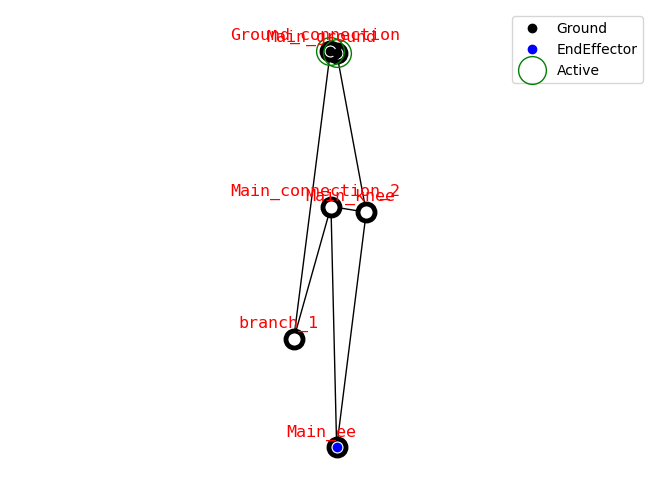

In [37]:
topology_index = 0
gm = get_preset_by_index_with_bounds(topology_index)
graph = gm.get_graph(np.array([-0.0063,  0.0023, -0.1615,  0.1506,  0.5051, -0.0372, -0.2922]))
#graph = gm.get_graph(np.array([-0.0063,  0.0023, -0.1615,  0.1,  0.4, -0.0372, -0.2922]))
#graph=gm.get_graph(gm.generate_central_from_mutation_range())
draw_joint_point(graph)


#np.array([-0.0063,  0.0023, -0.1615,  0.1506,  0.5051, -0.0372, -0.2922])

In [38]:
gm.mutation_ranges

{'Ground_connection_0': (-0.2, 0.0),
 'Ground_connection_2': (-0.028999999999999998, 0.07100000000000001),
 'Main_knee_2': (-0.30000000000000004, -0.1),
 'Main_connection_2_0': (-0.2, 0.2),
 'Main_connection_2_2': (-0.3, 0.6),
 'branch_1_0': (-0.05, 0.1),
 'branch_1_2': (-0.3, -0.1)}

In [39]:
# 1) trajectories

workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *get_workspace_trajectory([-0.12, -0.33], 0.09, 0.24, 30, 60))


ground_symmetric_step1 = convert_x_y_to_6d_traj_xz(*enhance_trajectory(create_simple_step_trajectory(
    starting_point=[-0.11, -0.32], step_height=0.07, step_width=0.22, n_points=50)))

ground_symmetric_step2 = convert_x_y_to_6d_traj_xz(*enhance_trajectory(create_simple_step_trajectory(
    starting_point=[-0.11 + 0.025, -0.32], step_height=0.06, step_width=-2*(-0.11 + 0.025), n_points=50)))

ground_symmetric_step3 = convert_x_y_to_6d_traj_xz(*enhance_trajectory(create_simple_step_trajectory(
    starting_point=[-0.11 + 2 * 0.025, -0.32], step_height=0.05, step_width=-2*(-0.11 + 2 * 0.025), n_points=50)))


central_vertical = convert_x_y_to_6d_traj_xz(
    *enhance_trajectory(get_vertical_trajectory(-0.32, 0.075, 0, 50)))

left_vertical = convert_x_y_to_6d_traj_xz(
    *enhance_trajectory(get_vertical_trajectory(-0.32, 0.065, -0.09, 50)))

right_vertical = convert_x_y_to_6d_traj_xz(
    *enhance_trajectory(get_vertical_trajectory(-0.32, 0.065, 0.09, 50)))
# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
acceleration_capability = MinAccelerationCapability(manipulability_key='Manip_Jacobian',
                                                    trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")

heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(
    error_key='error', jacobian_key="Manip_Jacobian")
# soft_constrain = PositioningConstrain(
#     error_calculator=error_calculator, points=[workspace_trajectory])
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [ground_symmetric_step1,
                                                                                   ground_symmetric_step2,
                                                                                   ground_symmetric_step3,
                                                                                   central_vertical,
                                                                                   left_vertical,
                                                                                   right_vertical])

# manager should be filled with trajectories and rewards using the manager API
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step1, 0)
reward_manager.add_trajectory(ground_symmetric_step2, 1)
reward_manager.add_trajectory(ground_symmetric_step3, 2)

reward_manager.add_trajectory(central_vertical, 3)
reward_manager.add_trajectory(left_vertical, 4)
reward_manager.add_trajectory(right_vertical, 5)

reward_manager.add_reward(acceleration_capability, 0, 1)
reward_manager.add_reward(acceleration_capability, 1, 1)
reward_manager.add_reward(acceleration_capability, 2, 1)

reward_manager.add_reward(heavy_lifting, 3, 1)
reward_manager.add_reward(heavy_lifting, 4, 1)
reward_manager.add_reward(heavy_lifting, 5, 1)

reward_manager.add_trajectory_aggregator([0, 1, 2], 'mean')
reward_manager.add_trajectory_aggregator([3, 4, 5], 'mean')

In [40]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)

In [41]:
pin.seed(1)
from auto_robot_design.pinokla.calc_criterion import (
    folow_traj_by_proximal_inv_k_2, iterate_over_q_space)


poses, q_array, constraint_errors, reach_array = folow_traj_by_proximal_inv_k_2(fixed_robot.model, fixed_robot.data, fixed_robot.constraint_models,
        fixed_robot.constraint_data, "EE", ground_symmetric_step1)

In [42]:
reach_array

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [43]:
pin.seed(1)
from auto_robot_design.pinokla.calc_criterion import (
    folow_traj_by_proximal_inv_k_2, iterate_over_q_space, closed_loop_ik_grad_follow)


poses, q_array, constraint_errors, reach_array = closed_loop_ik_grad_follow(fixed_robot.model, fixed_robot.data, fixed_robot.constraint_models,
        fixed_robot.constraint_data, "EE", ground_symmetric_step1)

In [44]:
reach_array

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [27]:
res_dict_fixed = iterate_over_q_space(fixed_robot, q_array, 'EE')


In [28]:
ev = np.linalg.eigvals(res_dict_fixed['J_closed'][1][[0,2],:])
max(abs(ev))/min(abs(ev))

17.993496633518145

In [45]:
q_array


array([[-0.06869861, -0.05004401,  0.14404745, -0.02379466,  0.0490995 ],
       [-0.15121664, -0.12084251,  0.31531235, -0.04183719,  0.08509038],
       [-0.15121518, -0.12084226,  0.31531168, -0.04183593,  0.08509018],
       [-0.15121372, -0.12084204,  0.315311  , -0.04183467,  0.08508991],
       [-0.15121227, -0.12084181,  0.31531031, -0.04183342,  0.08508964],
       [-0.15121082, -0.12084159,  0.31530963, -0.04183216,  0.08508938],
       [-0.15120937, -0.12084137,  0.31530894, -0.0418309 ,  0.08508911],
       [-0.15120792, -0.12084114,  0.31530826, -0.04182965,  0.08508884],
       [-0.15120647, -0.12084092,  0.31530757, -0.04182839,  0.08508858],
       [-0.15120502, -0.1208407 ,  0.31530689, -0.04182713,  0.08508831],
       [-0.15120357, -0.12084047,  0.3153062 , -0.04182588,  0.08508804],
       [-0.15120211, -0.12084025,  0.31530552, -0.04182462,  0.08508778],
       [-0.15120066, -0.12084003,  0.31530483, -0.04182337,  0.08508751],
       [-0.15119921, -0.1208398 ,  0.3

In [14]:
poses

array([[-2.19086703e-03,  4.84792361e-17, -3.98404943e-01],
       [-4.39027195e-03,  4.85147452e-17, -3.96804041e-01],
       [-6.59484942e-03,  4.85505776e-17, -3.95201354e-01],
       [-8.79469282e-03,  4.85861787e-17, -3.93600833e-01],
       [-1.09945770e-02,  4.86217852e-17, -3.92000323e-01],
       [-1.31945054e-02,  4.86573976e-17, -3.90399822e-01],
       [-1.53944732e-02,  4.86930153e-17, -3.88799332e-01],
       [-1.75944766e-02,  4.87286380e-17, -3.87198853e-01],
       [-1.97945124e-02,  4.87642654e-17, -3.85598384e-01],
       [-2.19945783e-02,  4.87998973e-17, -3.83997927e-01],
       [-2.41946722e-02,  4.88355335e-17, -3.82397480e-01],
       [-2.63947925e-02,  4.88711738e-17, -3.80797045e-01],
       [-2.85892236e-02,  4.89059958e-17, -3.79194754e-01],
       [-3.07894122e-02,  4.89416013e-17, -3.77593973e-01],
       [-3.29896431e-02,  4.89772162e-17, -3.75993232e-01],
       [-3.51899082e-02,  4.90128364e-17, -3.74392507e-01],
       [-3.73902064e-02,  4.90484619e-17

In [31]:
from pinocchio.visualize import MeshcatVisualizer
import meshcat


In [32]:
viz = MeshcatVisualizer(fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model)
viz.viewer = meshcat.Visualizer().open()
viz.clean()
viz.loadViewerModel()
poses, q_array, constraint_errors, reach_array = folow_traj_by_proximal_inv_k_2(fixed_robot.model, fixed_robot.data, fixed_robot.constraint_models,
        fixed_robot.constraint_data, "EE", ground_symmetric_step1, viz=viz)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
